In [1]:
import foundation
import numpy as np
import matplotlib.pyplot as plt

from foundation.utils import plotting

In [2]:
env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'scenarios/sinkhole',

    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #     "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #     {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        ('Upgrade', dict(upgrade_income=10.0, upgrade_labor=1.0)),
        ('Task', dict(move_labor=1.0, collect_labor=1.0)),
        ('Recharge', dict(recharge_income=10.0, recharge_labor=1.0)),
        ('Market', dict(order_labor=1.0, max_num_orders=5)),
        ('Shop', dict(shop_labor=1.0)),
        ('LaunchReadjustment', dict(is_biadjustment=True, adjustment_period=50, adjustment_rate_max=0.2, adjustment_rate_min=0.0, adjustment_rate_bin=0.1))
    ],

    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'base_launch_plan': {
        'Exp': 50,
        'Mat': 50,
        'Token': 20
    },
    'starting_player_token': 0,
    'starting_player_currency': 10,
    'normal_wear_and_tear_rate': 0.1,
    'player_utility_monetary_cost_dist': 'pareto', 
    'player_utility_nonmonetary_cost_dist': 'normal',
    'player_utility_income_fxrate': 1.,
    'adjustemt_type': 'planner',
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 5,          # Number of non-planner agents (must be >1)
    'world_size': [20, 20],  # [Height, Width] of the env world
    'episode_length': 100,  # Number of timesteps per episode
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,

    'full_observability': False,
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
}

In [6]:
def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())


def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""

    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [27]:
def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.

    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop

    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))

    obs = env.reset(force_dense_logging=do_dense_logging)

    adjustment_rates = env.components[-1].adjustment_rates

    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)
        ax2.clear()

        readjustment_plan = {k:adjustment_rates[int(v)-1] if v!=0 else 0 for k,v in zip(["Exp", "Mat", "Token"], actions['p'])}
        planner_launch_plan = {k: int(env.base_launch_plan[k]*(1+v)) for k, v in readjustment_plan.items()}
        for k,v in readjustment_plan.items():
            if v==0:
                readjustment_plan[k] = 'NO-OP'
            elif v>0:
                readjustment_plan[k] = '+' + str(v*100) + '%'
            else:
                readjustment_plan[k] = '-' + str(abs(v)*100) + '%'
        
        text = 'Steps: ' + str(t) + ' Durations: ' + str(env._durations) +'\n'
        text += 'Default launch plan: ' + str(env.base_launch_plan) + '\n'
        text += 'Current launch plan: ' + str(env.curr_launch_plan) + '\n'
        text += 'Last launch plan: ' + str(env.last_launch_plan) + '\n\n'

        metrics = env.scenario_metrics()
        text += 'Profitability: ' + str(round(metrics['social/productivity'], 2))+ ', Equality: ' +  str(round(metrics['social/equality'], 2)) +'\n'
        text += 'Planner: '+ str(readjustment_plan) +'\n'
        text += 'Planner launch plan: ' + str(planner_launch_plan)+ '\n\n\n'

        for i in range(len(env.all_agents)-1):
            act = env.dense_log["actions"][t][str(i)]
            act = act if len(act) > 0 else {'NO-OP': 1}
            text += 'Agent: ' + str(i) + ' :\nAction: ' + str(act) + '\nInventory: ' + str(env.world.agents[i].inventory) + '\nescrow: ' + str(
                env.world.agents[i].escrow) + '\nEndogenous: ' + str(
                env.world.agents[i].endogenous) + '\n================================\n'
        ax2.text(0.05, 0., text, fontsize=18)
        plt.xticks([])
        plt.yticks([])

        if ((t+1) % plot_every) == 0:
            plotting.do_plot(env, ax1, fig)

    if ((t+1) % plot_every) != 0:
        plotting.do_plot(env, ax1, fig)

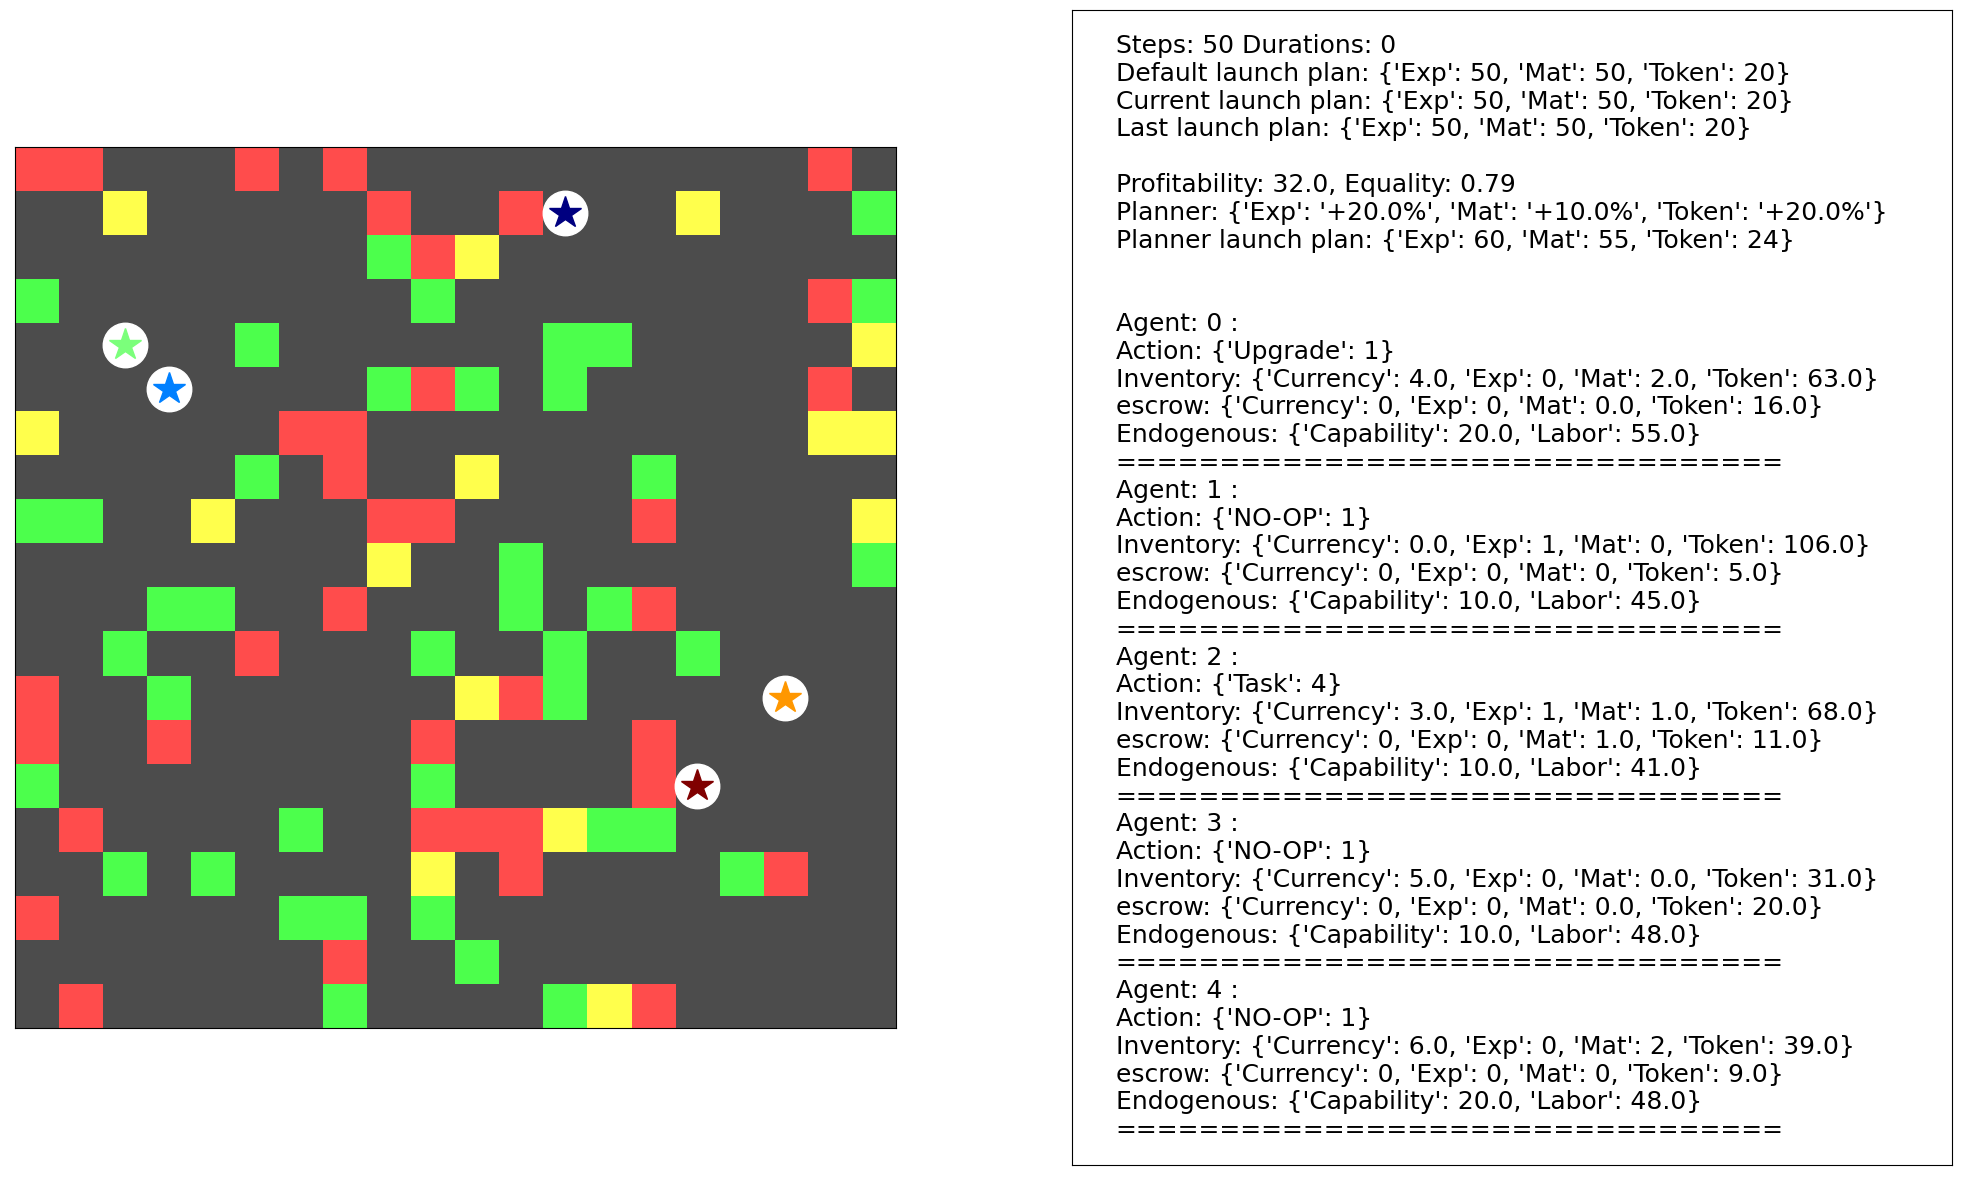

In [28]:
env = foundation.make_env_instance(**env_config)
play_random_episode(env, plot_every=1, do_dense_logging=True)
dense_log = env.previous_episode_dense_log

((<Figure size 1600x300 with 5 Axes>,
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 1600x400 with 2 Axes>,
  <Figure size 1600x800 with 10 Axes>),
 {'Sell Mat': [72, 90, 16, 77, 89, 53, 78, 48, 30, 33],
  'Buy Mat': [-45, -72, -29, -47, -61, -68, -102, -80, -52, -30],
  'Total': array([ 27,  18, -13,  30,  28, -15, -24, -32, -22,   3])},
 [226, 216, 183, 231, 228, 183, 171, 165, 179, 201],
 {'Mat': [{'t': 1,
    't_ask': 1,
    't_bid': 1,
    'commodity': 'Mat',
    'buyer': 6,
    'bid': 9,
    'bid_lifetime': 0,
    'seller': 3,
    'ask': 8,
    'ask_lifetime': 0,
    'price': 8,
    'cost': 8,
    'income': 8},
   {'t': 4,
    't_ask': 4,
    't_bid': 2,
    'commodity': 'Mat',
    'buyer': 3,
    'bid': 10,
    'bid_lifetime': 2,
    'seller': 7,
    'ask': 4,
    'ask_lifetime': 0,
    'price': 10,
    'cost': 10,
    'income': 10},
   {'t': 4,
    't_ask': 4,
    't_bid': 2,
    'commodity': 'Mat',
    'buyer': 9,
    'bid': 10,
    'bid_lifetime': 2,
    'seller': 6,
  

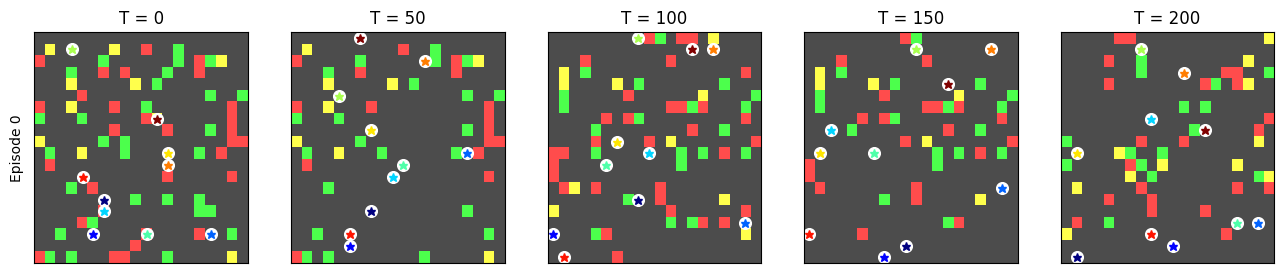

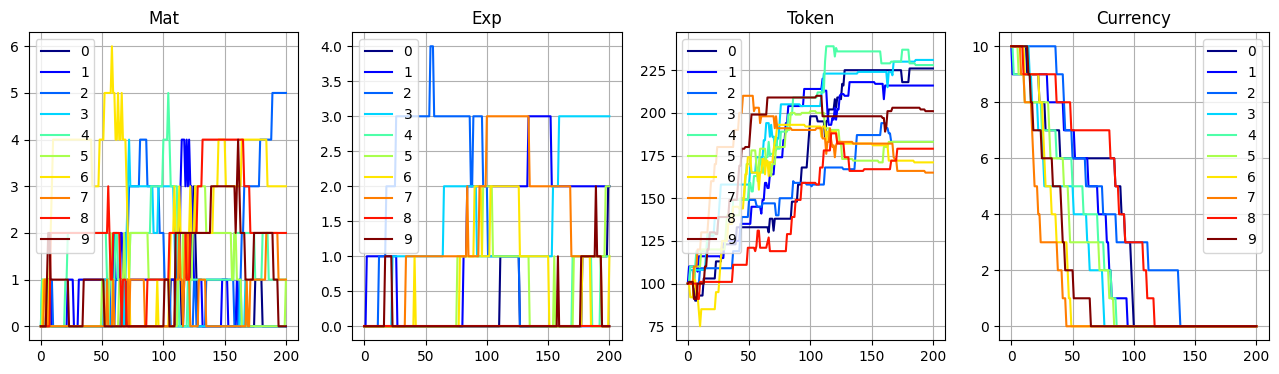

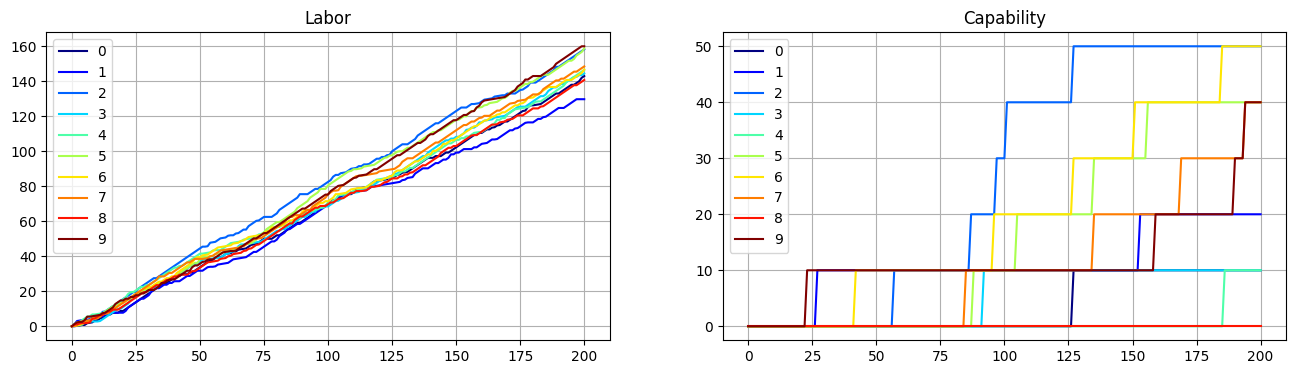

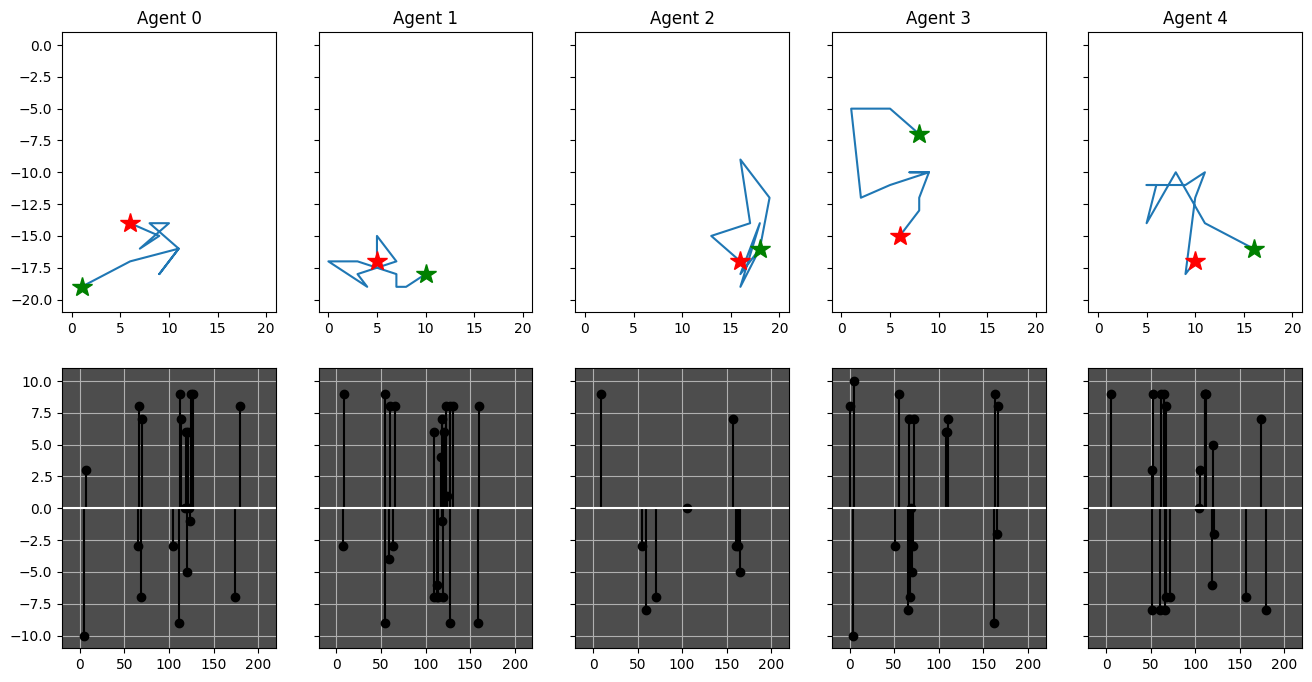

In [7]:
plotting.breakdown(dense_log)